<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Random-Walk-Prediction/blob/main/FMNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv  # Import the csv module

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error,r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import random
import os

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Call the function to set the seed
set_seed(42)

In [ ]:
!pip install pmdarima
import pmdarima as pm

## Raw Data

In [ ]:
# Load the exogenous and target CSV data (make sure the CSV files are in the correct path)
df_exo = pd.read_csv('/content/drive/MyDrive/Random_walk_prediction/FTSE_historical_data.csv')
df_target = pd.read_csv('/content/drive/MyDrive/Random_walk_prediction/BA_historical_data.csv')

In [ ]:
df_exo

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-04 00:00:00+01:00,6873.600098,6904.899902,6866.299805,6878.000000,689038700,0.0,0.0
1,2014-09-05 00:00:00+01:00,6878.000000,6885.000000,6829.100098,6855.100098,596549800,0.0,0.0
2,2014-09-08 00:00:00+01:00,6855.100098,6855.100098,6773.799805,6834.799805,754127500,0.0,0.0
3,2014-09-09 00:00:00+01:00,6834.799805,6846.200195,6812.500000,6829.000000,580798600,0.0,0.0
4,2014-09-10 00:00:00+01:00,6829.000000,6847.799805,6800.000000,6830.100098,585612100,0.0,0.0
...,...,...,...,...,...,...,...,...
2521,2024-08-29 00:00:00+01:00,8343.900391,8392.400391,8336.599609,8379.599609,613890100,0.0,0.0
2522,2024-08-30 00:00:00+01:00,8379.599609,8414.400391,8363.700195,8376.599609,1081528600,0.0,0.0
2523,2024-09-02 00:00:00+01:00,8376.599609,8380.099609,8353.200195,8363.799805,510920500,0.0,0.0
2524,2024-09-03 00:00:00+01:00,8363.799805,8381.000000,8286.599609,8298.500000,1022494600,0.0,0.0


In [ ]:
df_target

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-10-06 00:00:00-04:00,110.510974,110.597934,109.024046,109.789253,2681000,0.0,0.0
1,2014-10-07 00:00:00-04:00,109.145786,109.145786,107.206695,107.232780,3554900,0.0,0.0
2,2014-10-08 00:00:00-04:00,107.363218,108.771883,106.215414,108.676239,3610300,0.0,0.0
3,2014-10-09 00:00:00-04:00,108.450134,108.476219,106.354518,106.745819,4874700,0.0,0.0
4,2014-10-10 00:00:00-04:00,106.841500,107.267577,105.650215,105.650215,4214200,0.0,0.0
...,...,...,...,...,...,...,...,...
2512,2024-09-30 00:00:00-04:00,154.789993,155.300003,151.240005,152.039993,10902200,0.0,0.0
2513,2024-10-01 00:00:00-04:00,151.460007,156.399994,149.490005,154.220001,12588800,0.0,0.0
2514,2024-10-02 00:00:00-04:00,153.759995,154.850006,152.839996,152.889999,4357000,0.0,0.0
2515,2024-10-03 00:00:00-04:00,152.119995,152.740005,150.509995,150.520004,5704800,0.0,0.0


## Data preprocessing

In [ ]:
# Convert 'Date' column to datetime and normalize to UTC for both datasets
df_exo['Date'] = pd.to_datetime(df_exo['Date'], utc=True)
df_target['Date'] = pd.to_datetime(df_target['Date'], utc=True)

# Remove the time part, keeping only the date
df_exo['Date'] = df_exo['Date'].dt.date
df_target['Date'] = df_target['Date'].dt.date

In [ ]:
# Align exogenous and target datasets using target dates as reference, keeping all rows from target dataset
merged_df = pd.merge(df_target[['Date', 'Open', 'High', 'Low', 'Close']],
                     df_exo[['Date', 'Open']],
                     on='Date',
                     suffixes=('_target', '_exo'),
                     how='left')  # Use left join to keep all rows from the target dataset

# Fill NaN values in the exogenous data (exo columns) with the previous non-NaN values
merged_df.fillna(method='ffill', inplace=True)

<ipython-input-81-6c0e9a33d3e2>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [ ]:
# Corrected movement calculation: 1 if price at time t > price at t-1, else 0
merged_df['Movement_exo'] = merged_df['Open_exo'].diff().apply(lambda x: 1 if x > 0 else -1).fillna(0)
merged_df['Movement_target'] = merged_df['Close'].diff().apply(lambda x: 1 if x > 0 else -1).fillna(0)

In [ ]:
merged_df

,Date,Open_target,High,Low,Close,Open_exo,Movement_exo,Movement_target
0,2014-10-06,110.510974,110.597934,109.024046,109.789253,6563.700195,-1,-1
1,2014-10-07,109.145786,109.145786,107.206695,107.232780,6495.600098,-1,-1
2,2014-10-08,107.363218,108.771883,106.215414,108.676239,6482.200195,-1,1
3,2014-10-09,108.450134,108.476219,106.354518,106.745819,6431.899902,-1,-1
4,2014-10-10,106.841500,107.267577,105.650215,105.650215,6431.899902,-1,-1
...,...,...,...,...,...,...,...,...
2512,2024-09-30,154.789993,155.300003,151.240005,152.039993,8298.459961,-1,-1
2513,2024-10-01,151.460007,156.399994,149.490005,154.220001,8298.459961,-1,1
2514,2024-10-02,153.759995,154.850006,152.839996,152.889999,8298.459961,-1,-1
2515,2024-10-03,152.119995,152.740005,150.509995,150.520004,8298.459961,-1,-1


In [ ]:
# Check for missing Open prices
print("Missing exo Open prices:", merged_df['Open_exo'].isna().sum())
print("Missing target Open prices:", merged_df['Open_target'].isna().sum())

# Drop rows with missing Open prices if any exist
merged_df.dropna(subset=['Open_exo', 'Open_target'], inplace=True)

Missing exo Open prices: 0
Missing target Open prices: 0


In [ ]:
merged_df['Close_T+1'] = merged_df['Close'].shift(-1)

In [ ]:
merged_df['Open_exo_T+1'] = merged_df['Open_exo'].shift(-1)

In [ ]:
merged_df['Movement_exo_T+1'] = merged_df['Movement_exo'].shift(-1)

In [ ]:
merged_df['Movement_target_T+1'] = merged_df['Movement_target'].shift(-1)

In [ ]:
merged_df

,Date,Open_target,High,Low,Close,Open_exo,Movement_exo,Movement_target,Close_T+1,Open_exo_T+1,Movement_exo_T+1,Movement_target_T+1
0,2014-10-06,110.510974,110.597934,109.024046,109.789253,6563.700195,-1,-1,107.232780,6495.600098,-1.0,-1.0
1,2014-10-07,109.145786,109.145786,107.206695,107.232780,6495.600098,-1,-1,108.676239,6482.200195,-1.0,1.0
2,2014-10-08,107.363218,108.771883,106.215414,108.676239,6482.200195,-1,1,106.745819,6431.899902,-1.0,-1.0
3,2014-10-09,108.450134,108.476219,106.354518,106.745819,6431.899902,-1,-1,105.650215,6431.899902,-1.0,-1.0
4,2014-10-10,106.841500,107.267577,105.650215,105.650215,6431.899902,-1,-1,104.737167,6366.200195,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-09-30,154.789993,155.300003,151.240005,152.039993,8298.459961,-1,-1,154.220001,8298.459961,-1.0,1.0
2513,2024-10-01,151.460007,156.399994,149.490005,154.220001,8298.459961,-1,1,152.889999,8298.459961,-1.0,-1.0
2514,2024-10-02,153.759995,154.850006,152.839996,152.889999,8298.459961,-1,-1,150.520004,8298.459961,-1.0,-1.0
2515,2024-10-03,152.119995,152.740005,150.509995,150.520004,8298.459961,-1,-1,155.000000,8298.459961,-1.0,1.0


In [ ]:
new_df = merged_df[1:2501]

In [ ]:
new_df

,Date,Open_target,High,Low,Close,Open_exo,Movement_exo,Movement_target,Close_T+1,Open_exo_T+1,Movement_exo_T+1,Movement_target_T+1
1,2014-10-07,109.145786,109.145786,107.206695,107.232780,6495.600098,-1,-1,108.676239,6482.200195,-1.0,1.0
2,2014-10-08,107.363218,108.771883,106.215414,108.676239,6482.200195,-1,1,106.745819,6431.899902,-1.0,-1.0
3,2014-10-09,108.450134,108.476219,106.354518,106.745819,6431.899902,-1,-1,105.650215,6431.899902,-1.0,-1.0
4,2014-10-10,106.841500,107.267577,105.650215,105.650215,6431.899902,-1,-1,104.737167,6366.200195,-1.0,-1.0
5,2014-10-13,106.128451,107.119736,104.571958,104.737167,6366.200195,-1,-1,106.337128,6392.700195,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2024-09-06,162.500000,162.850006,156.699997,157.619995,8298.459961,-1,-1,162.910004,8298.459961,-1.0,1.0
2497,2024-09-09,162.300003,164.550003,161.110001,162.910004,8298.459961,-1,1,160.070007,8298.459961,-1.0,-1.0
2498,2024-09-10,162.610001,163.899994,157.929993,160.070007,8298.459961,-1,-1,161.330002,8298.459961,-1.0,1.0
2499,2024-09-11,159.789993,161.869995,156.100006,161.330002,8298.459961,-1,1,162.770004,8298.459961,-1.0,1.0


In [ ]:
# Divide the dataframe into 5 roughly equal parts
df_parts = np.array_split(new_df, 5)

# Initialize a list to store accuracies
accuracies = []

# Loop through the first four parts to calculate accuracies
for i in range(5):
    part = df_parts[i]
    # Calculate accuracy as the proportion of times the movement predictions match
    accuracy = np.mean(part['Movement_exo_T+1'] == part['Movement_target_T+1'])
    accuracies.append(accuracy)

# Calculate the mean, standard deviation, and coefficient of variation (CV) of the accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
cv_accuracy = std_accuracy / mean_accuracy if mean_accuracy != 0 else float('inf')

# Check if the mean accuracy is greater than 0.55 and if the CV is less than 0.2
mean_greater_than_56 = mean_accuracy > 0.56
cv_less_than_10 = cv_accuracy < 0.1

# Print results
print(f"Accuracies: {accuracies}")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracies: {std_accuracy}")
print(f"Coefficient of Variation: {cv_accuracy}")
print(f"Mean accuracy > 0.56: {mean_greater_than_56}")
print(f"CV < 0.1: {cv_less_than_10}")

Accuracies: [0.584, 0.542, 0.542, 0.574, 0.506]
Mean Accuracy: 0.5496000000000001
Standard Deviation of Accuracies: 0.02755068057235608
Coefficient of Variation: 0.05012860366149213
Mean accuracy > 0.56: False
CV < 0.1: True


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## FMNP

NN with 1 hidden layer

In [ ]:
# Define features
X = new_df[['Close','Movement_exo_T+1']]  # Features
y = new_df['Close_T+1']  # Target (S&P 500 open at time t+1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
model_FMNP = LinearRegression()
model_FMNP.fit(X_train, y_train)

y_pred_FMNP = model_FMNP.predict(X_test)

# y_pred_FMNP = y_pred_FMNP_normalized * (max_close - min_close) + min_close
y_pred_naive = X_test['Close']

# Calculate metrics for the FMNP forecast
mse_FMNP = mean_squared_error(y_test, y_pred_FMNP)
rmse_FMNP = np.sqrt(mse_FMNP)
mae_FMNP = mean_absolute_error(y_test, y_pred_FMNP)
msle_FMNP = mean_squared_log_error(y_test, y_pred_FMNP)
r2_FMNP = r2_score(y_test, y_pred_FMNP)


# Calculate metrics for the naive forecast
mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(y_test, y_pred_naive)
msle_naive = mean_squared_log_error(y_test, y_pred_naive)
r2_naive = r2_score(y_test, y_pred_naive)

# Display the comparison of RMSE values
print("Rooted Mean Squared Error (FMNP): {:.4f}".format(rmse_FMNP))
print("Rooted Mean Squared Error (Naive Forecast): {:.4f}".format(rmse_naive))

# Compare the two methods
if rmse_FMNP < rmse_naive:
    print("The FMNP model outperforms the naive forecast.")
else:
    print("The naive forecast outperforms the FMNP model.")

# Display the comparison of MAE values
print("Mean Absolute Error (FMNP): {:.4f}".format(mae_FMNP))
print("Mean Absolute Error (Naive Forecast): {:.4f}".format(mae_naive))

# Compare the two methods
if mae_FMNP < mae_naive:
    print("The FMNP model outperforms the naive forecast.")
else:
    print("The naive forecast outperforms the FMNP model.")

# Display the comparison of MSLE values
print("Mean Squared Log Error (FMNP): {:.6f}".format(msle_FMNP))
print("Mean Squared Log Error (Naive Forecast): {:.6f}".format(msle_naive))

# Compare the two methods
if msle_FMNP < msle_naive:
    print("The FMNP model outperforms the naive forecast.")
else:
    print("The naive forecast outperforms the FMNP model.")

# Display the comparison of R^2 values
print("R Squared (FMNP): {:.6f}".format(r2_FMNP))
print("R Squared (Naive Forecast): {:.6f}".format(r2_naive))

# Compare the two methods
if np.abs(r2_FMNP-1) < np.abs(r2_naive-1):
    print("The FMNP model outperforms the naive forecast.")
else:
    print("The naive forecast outperforms the FMNP model.")

Rooted Mean Squared Error (FMNP): 1.0040
Rooted Mean Squared Error (Naive Forecast): 1.0129
The FMNP model outperforms the naive forecast.
Mean Absolute Error (FMNP): 0.7409
Mean Absolute Error (Naive Forecast): 0.7456
The FMNP model outperforms the naive forecast.
Mean Squared Log Error (FMNP): 0.000419
Mean Squared Log Error (Naive Forecast): 0.000428
The FMNP model outperforms the naive forecast.
R Squared (FMNP): 0.961543
R Squared (Naive Forecast): 0.960854
The FMNP model outperforms the naive forecast.


## Direct Fusion

In [ ]:
# # Step 1: Calculate average accuracy for the first four parts to estimate acc_movement
# acc_movement = np.mean(accuracies[:4])

# # Step 2: Compute the scaling factor based on the accuracy of movement prediction
# c = 2 * acc_movement - 1

In [ ]:
# # Define movement prediction for time t+1
# movement_exo = np.array(X_test['Movement_exo_T+1'])

In [ ]:
# # Generate naive forecast for the training set
# naive_train = np.array(X_train['Close'])
# raw_y_train =  np.array(y_train)

In [ ]:
# # Calculate residuals in the training set
# residuals_train = np.abs(raw_y_train - naive_train)

# # Calculate the mean of the residuals
# bar_epsilon = np.mean(residuals_train)

In [ ]:
# # Apply the fusion method for predicting S&P 500 open price at time t+1
# fusion_prediction = y_naive_pred + c * movement_exo * bar_epsilon

In [ ]:
# # Calculate the Metrics for the fusion forecast
# mse_fusion = mean_squared_error(y_test, fusion_prediction)
# rmse_fusion = np.sqrt(mse_fusion)
# mae_fusion = mean_absolute_error(y_test, fusion_prediction)
# msle_fusion = mean_squared_log_error(y_test, fusion_prediction)
# r2_fusion = r2_score(y_test, fusion_prediction)

# # Display the comparison of RMSE values
# print("Rooted Mean Squared Error (Fusion Forecast): {:.4f}".format(rmse_fusion))
# print("Rooted Mean Squared Error (Naive Forecast): {:.4f}".format(rmse_naive))

# # Compare the two methods
# if rmse_fusion < rmse_naive:
#     print("The FMNP model outperforms the naive forecast.")
# else:
#     print("The naive forecast outperforms the FMNP model.")

# # Display the comparison of MAE values
# print("Mean Absolute Error (Fusion Forecast): {:.4f}".format(mae_fusion))
# print("Mean Absolute Error (Naive Forecast): {:.4f}".format(mae_naive))

# # Compare the two methods
# if mae_fusion < mae_naive:
#     print("The FMNP model outperforms the naive forecast.")
# else:
#     print("The naive forecast outperforms the FMNP model.")

# # Display the comparison of MSLE values
# print("Mean Squared Log Error (Fusion Forecast): {:.6f}".format(msle_fusion))
# print("Mean Squared Log Error (Naive Forecast): {:.6f}".format(msle_naive))

# # Compare the two methods
# if msle_fusion < msle_naive:
#     print("The FMNP model outperforms the naive forecast.")
# else:
#     print("The naive forecast outperforms the FMNP model.")

# # Display the comparison of R^2 values
# print("R Squared (Fusion Forecast): {:.6f}".format(r2_fusion))
# print("R Squared (Naive Forecast): {:.6f}".format(r2_naive))

# # Compare the two methods
# if r2_fusion < r2_naive:
#     print("The FMNP model outperforms the naive forecast.")
# else:
#     print("The naive forecast outperforms the FMNP model.")

## Baselines

### ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5189.443, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5188.447, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5187.868, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5187.973, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5187.363, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.685 seconds
MSE_ARIMA: 185.62299688085102
RMSE_ARIMA: 13.62435308118705
MAE_ARIMA: 12.706742561340322
MSLE_ARIMA: 0.09083902610198527
R2_ARIMA: -6.081939798833793


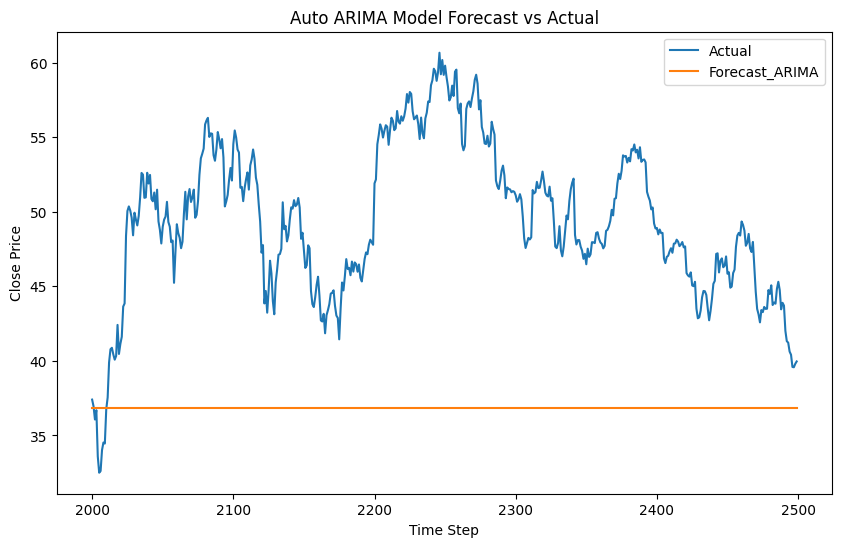

In [ ]:
# Step 1: Split the data into train and test sets
train_set_ARIMA = np.array(y_train)
test_set_ARIMA = np.array(y_test)

# Step 2: Fit the auto_arima model on the training set
model_ARIMA = pm.auto_arima(train_set_ARIMA,
                      start_p=1, start_q=1,
                      max_p=10, max_q=10,
                      seasonal=False,  # Change to True if you want seasonal ARIMA
                      stepwise=True,   # Use a stepwise approach to search for the best model
                      trace=True)      # Print the output of the model fitting process

# Step 3: Make predictions on the test set
y_pred_ARIMA = model_ARIMA.predict(n_periods=len(test_set_ARIMA))

# Step 4: Evaluate the model (e.g., using MSE)
mse_ARIMA = mean_squared_error(y_test, y_pred_ARIMA)
rmse_ARIMA = np.sqrt(mse_ARIMA)
mae_ARIMA = mean_absolute_error(y_test, y_pred_ARIMA)
msle_ARIMA = mean_squared_log_error(y_test, y_pred_ARIMA)
r2_ARIMA = r2_score(y_test, y_pred_ARIMA)

print(f'MSE_ARIMA: {mse_ARIMA}')
print(f'RMSE_ARIMA: {rmse_ARIMA}')
print(f'MAE_ARIMA: {mae_ARIMA}')
print(f'MSLE_ARIMA: {msle_ARIMA}')
print(f'R2_ARIMA: {r2_ARIMA}')
# Step 5: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2000, 2500), y_test, label='Actual')
plt.plot(range(2000, 2500), y_pred_ARIMA, label='Forecast_ARIMA')
plt.title('Auto ARIMA Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### MA

MSE_MA: 2.4679598733458588
RMSE_MA: 1.5709741797196601
MAE_MA: 1.1926611282348634
MSLE_MA: 0.0010494882473151472
R2_MA: 0.9058417138896226


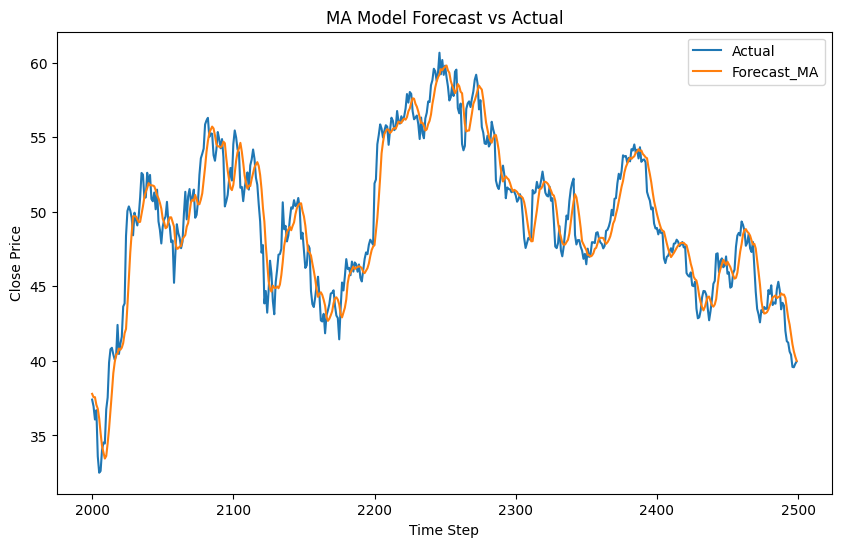

In [ ]:
ma_window = 5  # You can choose the window size that suits your needs
ma_array = new_df['Close'].rolling(window=ma_window).mean().to_numpy()
y_pred_MA = ma_array[-500:]

# Step 4: Evaluate the model (e.g., using MSE)
mse_MA = mean_squared_error(y_test, y_pred_MA)
rmse_MA = np.sqrt(mse_MA)
mae_MA = mean_absolute_error(y_test, y_pred_MA)
msle_MA = mean_squared_log_error(y_test, y_pred_MA)
r2_MA = r2_score(y_test, y_pred_MA)

print(f'MSE_MA: {mse_MA}')
print(f'RMSE_MA: {rmse_MA}')
print(f'MAE_MA: {mae_MA}')
print(f'MSLE_MA: {msle_MA}')
print(f'R2_MA: {r2_MA}')
# Step 5: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2000, 2500), y_test, label='Actual')
plt.plot(range(2000, 2500), y_pred_MA, label='Forecast_MA')
plt.title('MA Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### MLP

In [ ]:
# # Define features
# X_LR = new_df[['Close','Movement_exo_T+1']]  # Features
# y = new_df['Close_T+1']  # Target (S&P 500 open at time t+1)

# # Split the data into training and testing sets
# X_LR_train, X_LR_test, y_train, y_test = train_test_split(X_LR, y, test_size=0.2, shuffle = False)

In [ ]:
# MLP Regressor with one hidden layer
mlp_regressor = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', solver='adam', max_iter=100)

# Train the model
mlp_regressor.fit(X_train, y_train)

y_pred_MLP = mlp_regressor.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE_MLP: 0.9957213002839518
RMSE_MLP: 0.9978583568242297
MAE_MLP: 0.7358698674572449
MSLE_MLP: 0.00041329443176398907
R2_MLP: 0.9620109661867284


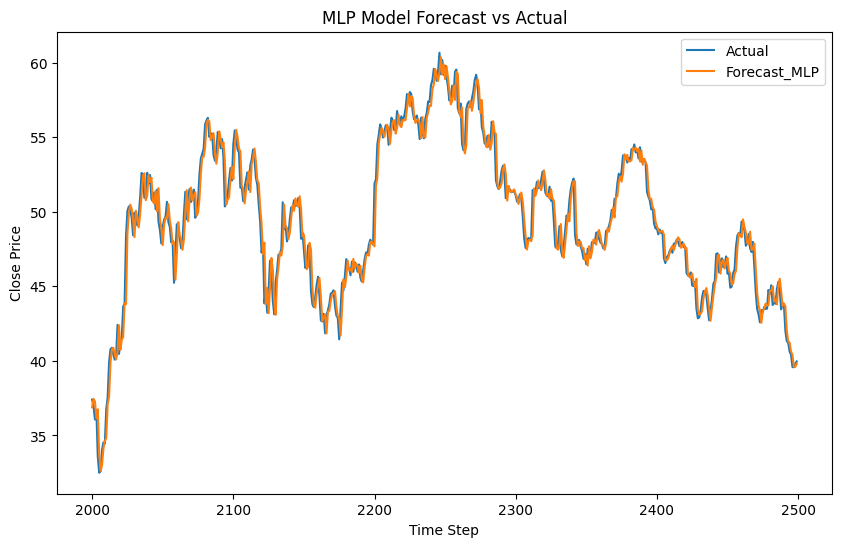

In [ ]:
# Step 4: Evaluate the model (e.g., using MSE)
mse_MLP = mean_squared_error(y_test, y_pred_MLP)
rmse_MLP = np.sqrt(mse_MLP)
mae_MLP = mean_absolute_error(y_test, y_pred_MLP)
msle_MLP = mean_squared_log_error(y_test, y_pred_MLP)
r2_MLP = r2_score(y_test, y_pred_MLP)

print(f'MSE_MLP: {mse_MLP}')
print(f'RMSE_MLP: {rmse_MLP}')
print(f'MAE_MLP: {mae_MLP}')
print(f'MSLE_MLP: {msle_MLP}')
print(f'R2_MLP: {r2_MLP}')
# Step 5: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2000, 2500), y_test, label='Actual')
plt.plot(range(2000, 2500), y_pred_MLP, label='Forecast_MLP')
plt.title('MLP Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### DNN

In [ ]:
# Create a sequential model_DNN
model_DNN = Sequential()

# First Hidden Layer (Fully connected with input specification)
model_DNN.add(Dense(units=64, activation='relu', input_dim=2))  # Fully connected to 2 input features

# Second Hidden Layer (Fully connected)
model_DNN.add(Dense(units=64, activation='relu'))

# Third Hidden Layer (Fully connected)
model_DNN.add(Dense(units=64, activation='relu'))

# Output Layer (For regression, using a single neuron)
model_DNN.add(Dense(units=1, activation='linear'))  # Use 'softmax' or 'sigmoid' for classification tasks

optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001
model_DNN.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model_DNN on the training data
model_DNN.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 967.9017
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2188 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3360 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7945
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7913 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7915 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7908 
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7891 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7872 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7863 
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7847 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7845 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7840  
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7837 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7836

In [ ]:
y_pred_DNN = model_DNN.predict(X_test)
# y_pred_DNN = y_pred_DNN_normalized * (max_close - min_close) + min_close

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


MSE_DNN: 1.0654260069741284
RMSE_DNN: 1.0321947524445803
MAE_DNN: 0.7810635833740235
MSLE_DNN: 0.00044442104897068424
R2_DNN: 0.9593515729823828


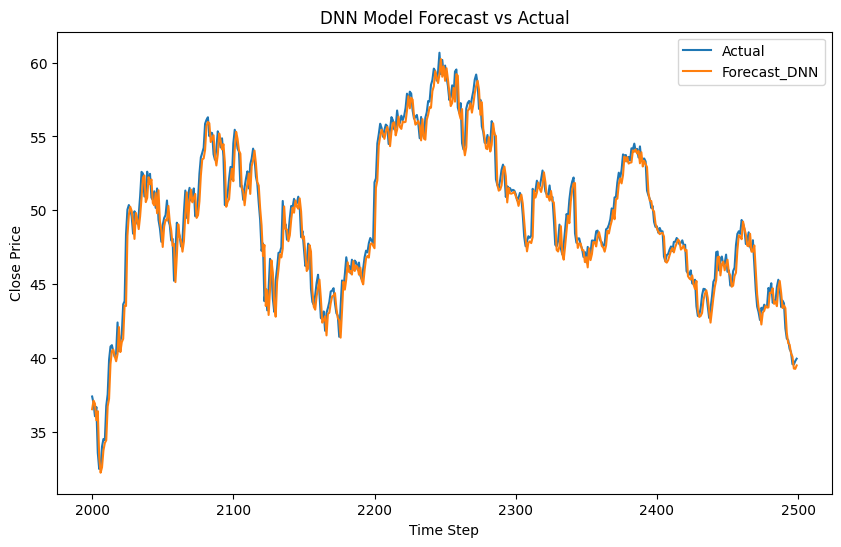

In [ ]:
# Step 4: Evaluate the model (e.g., using MSE)
mse_DNN = mean_squared_error(y_test, y_pred_DNN)
rmse_DNN = np.sqrt(mse_DNN)
mae_DNN = mean_absolute_error(y_test, y_pred_DNN)
msle_DNN = mean_squared_log_error(y_test, y_pred_DNN)
r2_DNN = r2_score(y_test, y_pred_DNN)

print(f'MSE_DNN: {mse_DNN}')
print(f'RMSE_DNN: {rmse_DNN}')
print(f'MAE_DNN: {mae_DNN}')
print(f'MSLE_DNN: {msle_DNN}')
print(f'R2_DNN: {r2_DNN}')
# Step 5: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2000, 2500), y_test, label='Actual')
plt.plot(range(2000, 2500), y_pred_DNN, label='Forecast_DNN')
plt.title('DNN Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### LSTM

In [ ]:
# Step 1: Ensure that the sequences and target arrays are created correctly
time_steps = 10

def create_univariate_sequences(df, time_steps):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)]['Close_T+1'].values)  # Sequence of past time steps
        y.append(df.iloc[i + time_steps]['Close_T+1'])  # Target is the next time step's value
    return np.array(X), np.array(y)

X_sequence, y_sequence = create_univariate_sequences(new_df, time_steps)

# Reshape the input data to 3D for LSTM
X_sequence = X_sequence.reshape((X_sequence.shape[0], X_sequence.shape[1], 1))

# Step 2: Split the data into training and testing sets
X_sequence_train = X_sequence[:-500]
y_sequence_train = y_sequence[:-500]
X_sequence_test = X_sequence[-500:]
y_sequence_test = y_sequence[-500:]

In [ ]:
# Step 3: Build the LSTM model
model_LSTM = Sequential()

# First LSTM layer with 100 units and dropout
model_LSTM.add(LSTM(100, return_sequences=False, input_shape=(X_sequence_train.shape[1], X_sequence_train.shape[2])))
# model_LSTM.add(Dropout(0.2))

# Second LSTM layer with 100 units and dropout
# model_LSTM.add(LSTM(100, return_sequences=False))
# model_LSTM.add(Dropout(0.2))

# Output layer
model_LSTM.add(Dense(1))  # Output is the predicted Close price at time t+1

# Step 4: Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error')

# Step 5: Train the model
history_LSTM = model_LSTM.fit(X_sequence_train, y_sequence_train, epochs=400, batch_size=64)

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2223.8293
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1769.8424
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1311.2876
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1023.7286
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 799.6729
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 644.0112
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 531.4623
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 444.2424
Epoch 9/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 373.9939
Epoch 10/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 315.8083
Epoch 11/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266.9832
Epoch 12/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 225.7575
Epoch 13/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 190.5717
Epoch 14/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 160.5489
Epoch 15/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE_LSTM: 1.7475331651895831
RMSE_LSTM: 1.3219429508074783
MAE_LSTM: 1.0381448593139648
MSLE_LSTM: 0.0007376229360808348
R2_LSTM: 0.9333276324577281


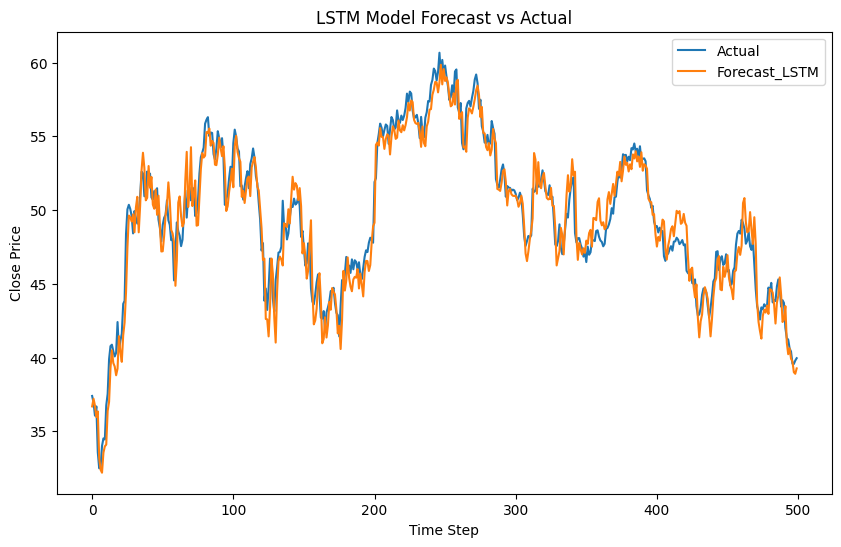

In [ ]:
# Step 6: Make predictions on the test set
y_pred_LSTM = model_LSTM.predict(X_sequence_test)

# Step 7: Evaluate the model using common metrics
mse_LSTM = mean_squared_error(y_sequence_test, y_pred_LSTM)
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = mean_absolute_error(y_sequence_test, y_pred_LSTM)
msle_LSTM = mean_squared_log_error(y_sequence_test, y_pred_LSTM)
r2_LSTM = r2_score(y_sequence_test, y_pred_LSTM)

print(f'MSE_LSTM: {mse_LSTM}')
print(f'RMSE_LSTM: {rmse_LSTM}')
print(f'MAE_LSTM: {mae_LSTM}')
print(f'MSLE_LSTM: {msle_LSTM}')
print(f'R2_LSTM: {r2_LSTM}')

# Step 8: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_sequence_test)), y_sequence_test, label='Actual')
plt.plot(range(len(y_sequence_test)), y_pred_LSTM, label='Forecast_LSTM')
plt.title('LSTM Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### CNN-LSTM

In [ ]:
# Build and train your model as usual
model_CNNLSTM = Sequential()

# CNN Layer
model_CNNLSTM.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_sequence_train.shape[1], X_sequence_train.shape[2])))


# First LSTM layer with 100 units and dropout
model_CNNLSTM.add(LSTM(100, return_sequences=False))


# Second LSTM layer with 100 units and dropout
# model_CNNLSTM.add(LSTM(100, return_sequences=False))
# model_CNNLSTM.add(Dropout(0.2))

# Output layer
model_CNNLSTM.add(Dense(1))  # Output is the predicted Close price at time t+1

# Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=0.001)
model_CNNLSTM.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history_CNNLSTM = model_CNNLSTM.fit(X_sequence_train, y_sequence_train, epochs=400, batch_size=64, validation_data=(X_sequence_test, y_sequence_test))

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1943.7952 - val_loss: 1488.7720
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1347.4731 - val_loss: 1113.1184
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1045.1152 - val_loss: 894.1181
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 868.8160 - val_loss: 703.8354
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 716.9738 - val_loss: 568.7998
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 606.9700 - val_loss: 458.5873
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 517.0861 - val_loss: 367.7916
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 442.2892 - val_loss: 292.8781
Epoch 9/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 379.3206 - val_loss: 231.0531
Epoch 10/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 325.5483 - val_loss: 179.7765
Epoch 11/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 278.5572 - val_loss: 136.6744
Epoch 12/400
32/32 ━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE_CNNLSTM: 1.5425258472092682
RMSE_CNNLSTM: 1.2419846404884676
MAE_CNNLSTM: 0.9683163146972659
MSLE_CNNLSTM: 0.0006662980635119109
R2_CNNLSTM: 0.9411491282241653


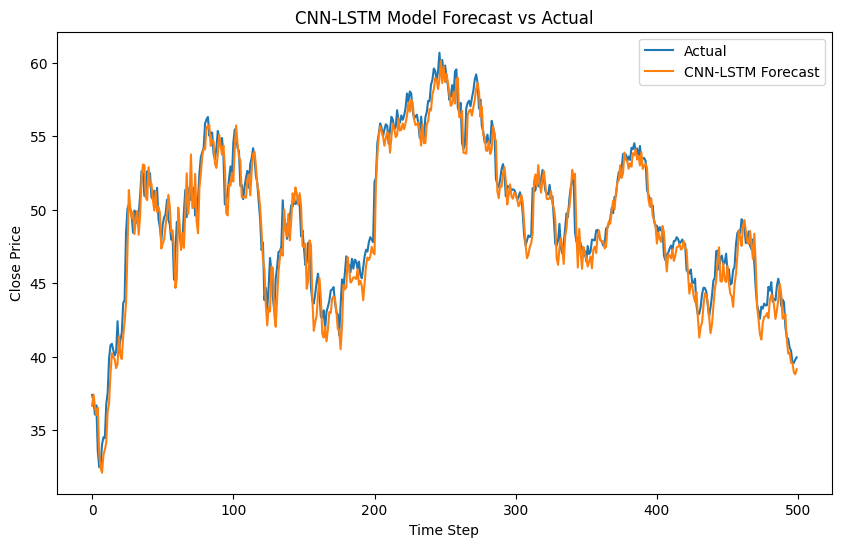

In [ ]:
# Step 6: Make predictions on the test set
y_pred_CNNLSTM = model_CNNLSTM.predict(X_sequence_test)

# Step 7: Evaluate the model using common metrics
mse_CNNLSTM = mean_squared_error(y_sequence_test, y_pred_CNNLSTM)
rmse_CNNLSTM = np.sqrt(mse_CNNLSTM)
mae_CNNLSTM = mean_absolute_error(y_sequence_test, y_pred_CNNLSTM)
msle_CNNLSTM = mean_squared_log_error(y_sequence_test, y_pred_CNNLSTM)
r2_CNNLSTM = r2_score(y_sequence_test, y_pred_CNNLSTM)

print(f'MSE_CNNLSTM: {mse_CNNLSTM}')
print(f'RMSE_CNNLSTM: {rmse_CNNLSTM}')
print(f'MAE_CNNLSTM: {mae_CNNLSTM}')
print(f'MSLE_CNNLSTM: {msle_CNNLSTM}')
print(f'R2_CNNLSTM: {r2_CNNLSTM}')

# Step 8: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_sequence_test)), y_sequence_test, label='Actual')
plt.plot(range(len(y_sequence_test)), y_pred_CNNLSTM, label='CNN-LSTM Forecast')
plt.title('CNN-LSTM Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Comparison

In [ ]:
y_test.shape

(500,)

In [ ]:

data_test = {
    "Actual": np.ravel(y_test),
    "FMNP": np.ravel(y_pred_FMNP),
    "Naive": np.ravel(y_pred_naive),
    "ARIMA": np.ravel(y_pred_ARIMA),
    "MA": np.ravel(y_pred_MA),
    "MLP": np.ravel(y_pred_MLP),
    "DNN": np.ravel(y_pred_DNN),
    "LSTM": np.ravel(y_pred_LSTM),
    "CNN-LSTM": np.ravel(y_pred_CNNLSTM)
}

# Create a DataFrame
df_test = pd.DataFrame(data_test)

# Save to CSV
df_test.to_csv("/content/drive/MyDrive/Random_walk_prediction/files/SLB_predictions.csv", index=False)


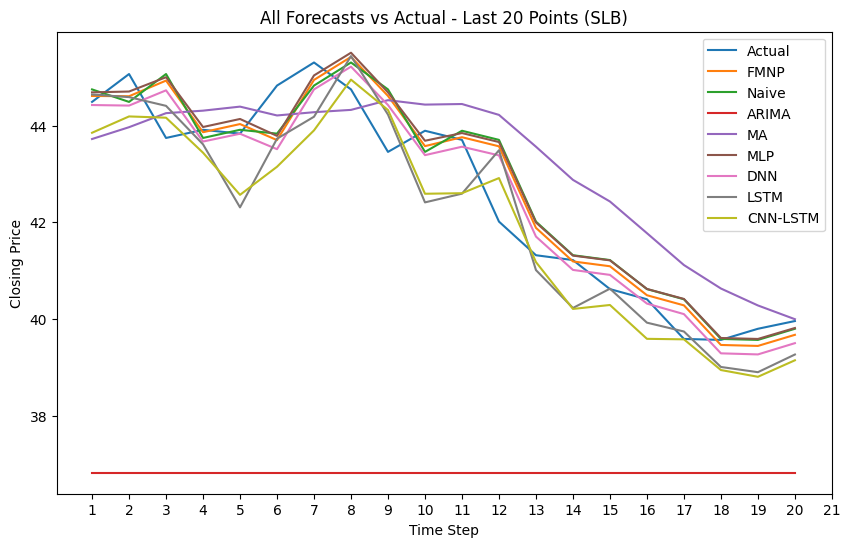

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), y_test[-20:], label='Actual')
plt.plot(range(1, 21), y_pred_FMNP[-20:], label='FMNP')
plt.plot(range(1, 21), y_pred_naive[-20:], label='Naive')
plt.plot(range(1, 21), y_pred_ARIMA[-20:], label='ARIMA')
plt.plot(range(1, 21), y_pred_MA[-20:], label='MA')
plt.plot(range(1, 21), y_pred_MLP[-20:], label='MLP')
plt.plot(range(1, 21), y_pred_DNN[-20:], label='DNN')
plt.plot(range(1, 21), y_pred_LSTM[-20:], label='LSTM')
plt.plot(range(1, 21), y_pred_CNNLSTM[-20:], label='CNN-LSTM')
plt.title('All Forecasts vs Actual - Last 20 Points (SLB)')
plt.xlabel('Time Step')
# Force the x-axis to use integer values
plt.xticks(range(1, 21 + 1, 1))  # Set ticks to integer range
plt.ylabel('Closing Price')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Random_walk_prediction/figures/SLB_result.png', dpi=300)
plt.show()

In [ ]:
data = {
    'Model': ['FMNP','Naive','ARIMA','MA','MLP','DNN','LSTM', 'CNN-LSTM'],
    'RMSE': [rmse_FMNP, rmse_naive,rmse_ARIMA,rmse_MA,rmse_MLP,rmse_DNN,rmse_LSTM,rmse_CNNLSTM],
    'MAE': [mae_FMNP, mae_naive,mae_ARIMA,mae_MA,mae_MLP,mae_DNN,mae_LSTM,mae_CNNLSTM],
    'MSLE': [msle_FMNP, msle_naive,msle_ARIMA,msle_MA,msle_MLP,msle_DNN,msle_LSTM,msle_CNNLSTM],
    'R^2': [r2_FMNP, r2_naive,r2_ARIMA,r2_MA,r2_MLP,r2_DNN,r2_LSTM,r2_CNNLSTM]
}

In [ ]:
# Create DataFrame
df_results_row = pd.DataFrame(data)

In [ ]:
df_results_row

,Model,RMSE,MAE,MSLE,R^2
0,FMNP,1.003984,0.740932,0.000419,0.961543
1,Naive,1.012942,0.745561,0.000428,0.960854
2,ARIMA,13.624353,12.706743,0.090839,-6.081940
3,MA,1.570974,1.192661,0.001049,0.905842
4,MLP,0.997858,0.735870,0.000413,0.962011
5,DNN,1.032195,0.781064,0.000444,0.959352
6,LSTM,1.321943,1.038145,0.000738,0.933328
7,CNN-LSTM,1.241985,0.968316,0.000666,0.941149


In [ ]:
# # Plotting the RMSE values for each model with Naive as reference line
# plt.figure(figsize=(10, 6))
# plt.bar(df_results_row['Model'], df_results_row['RMSE'], color='skyblue')

# # Adding a reference line for the Naive model's RMSE
# naive_rmse = df_results_row.loc[df_results_row['Model'] == 'Naive', 'RMSE'].values[0]
# plt.axhline(y=naive_rmse, color='r', linestyle='--', label=f'Naive RMSE = {naive_rmse:.4f}')

# # Zooming in to highlight the improvements (focus on lower RMSE values)
# plt.ylim(0.7, 1.1)

# # Adding titles and labels
# plt.title('RMSE Comparison Across Models (SLB', fontsize=14)
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('RMSE', fontsize=12)
# plt.legend()

# # Show plot
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Random_walk_prediction/figures/SLB_RMSE.png', dpi=300)
# plt.show()

## Ablation study

### LR (Input 2)

In [ ]:
# Define features
X_input2 = new_df[['Open_target',	'High',	'Low', 'Close', 'Movement_exo_T+1']]  # Features
y_input2 = new_df['Close_T+1']  # Target (S&P 500 open at time t+1)

# Split the data into training and testing sets
X_input2_train, X_input2_test, y_input2_train, y_input2_test = train_test_split(X_input2, y_input2, test_size=0.2, shuffle = False)

In [ ]:
model_input2 = LinearRegression()
model_input2.fit(X_input2_train, y_input2_train)

LinearRegression()

MSE_input2: 1.0078994584386107
RMSE_input2: 1.0039419596961823
MAE_input2: 0.7401364938471281
MSLE_input2: 0.0004194584938396513
R2_input2: 0.9615463417363036


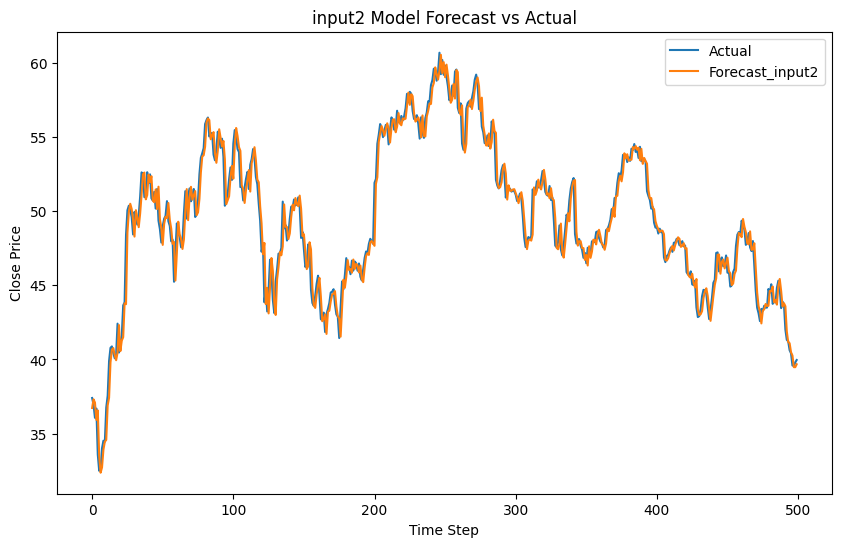

In [ ]:
# Step 6: Make predictions on the test set
y_pred_input2 = model_input2.predict(X_input2_test)

# Step 7: Evaluate the model using common metrics
mse_input2 = mean_squared_error(y_sequence_test, y_pred_input2)
rmse_input2 = np.sqrt(mse_input2)
mae_input2 = mean_absolute_error(y_sequence_test, y_pred_input2)
msle_input2 = mean_squared_log_error(y_sequence_test, y_pred_input2)
r2_input2 = r2_score(y_sequence_test, y_pred_input2)

print(f'MSE_input2: {mse_input2}')
print(f'RMSE_input2: {rmse_input2}')
print(f'MAE_input2: {mae_input2}')
print(f'MSLE_input2: {msle_input2}')
print(f'R2_input2: {r2_input2}')

# Step 8: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_sequence_test)), y_sequence_test, label='Actual')
plt.plot(range(len(y_sequence_test)), y_pred_input2, label='Forecast_input2')
plt.title('input2 Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### LR (Input 3)

In [ ]:
# Define features
X_input3 = new_df[['Open_target',	'High',	'Low', 'Close']]  # Features
y_input3 = new_df['Close_T+1']  # Target (S&P 500 open at time t+1)

# Split the data into training and testing sets
X_input3_train, X_input3_test, y_input3_train, y_input3_test = train_test_split(X_input3, y_input3, test_size=0.2, shuffle = False)

In [ ]:
model_input3 = LinearRegression()
model_input3.fit(X_input3_train, y_input3_train)

LinearRegression()

MSE_input3: 1.0241430048431694
RMSE_input3: 1.0119995083216047
MAE_input3: 0.7455616091284414
MSLE_input3: 0.00042704163762870783
R2_input3: 0.960926613471543


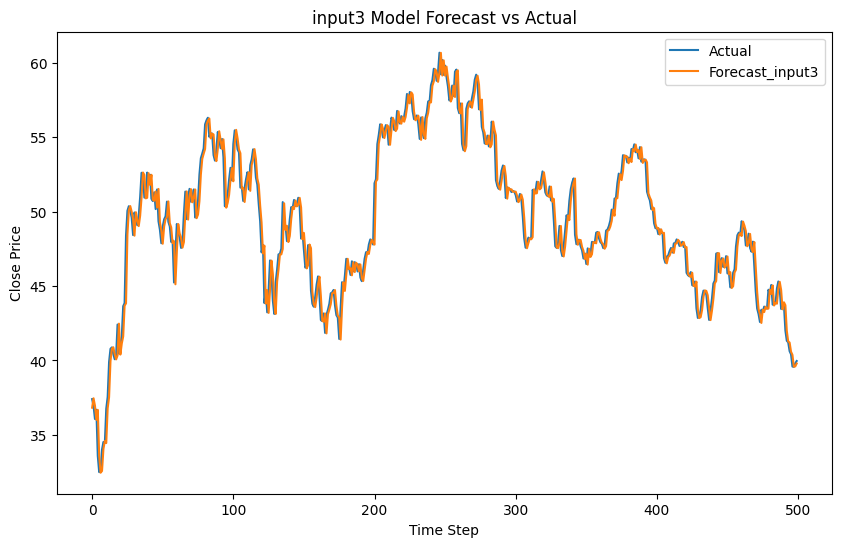

In [ ]:
# Step 6: Make predictions on the test set
y_pred_input3 = model_input3.predict(X_input3_test)

# Step 7: Evaluate the model using common metrics
mse_input3 = mean_squared_error(y_sequence_test, y_pred_input3)
rmse_input3 = np.sqrt(mse_input3)
mae_input3 = mean_absolute_error(y_sequence_test, y_pred_input3)
msle_input3 = mean_squared_log_error(y_sequence_test, y_pred_input3)
r2_input3 = r2_score(y_sequence_test, y_pred_input3)

print(f'MSE_input3: {mse_input3}')
print(f'RMSE_input3: {rmse_input3}')
print(f'MAE_input3: {mae_input3}')
print(f'MSLE_input3: {msle_input3}')
print(f'R2_input3: {r2_input3}')

# Step 8: Optional - Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_sequence_test)), y_sequence_test, label='Actual')
plt.plot(range(len(y_sequence_test)), y_pred_input3, label='Forecast_input3')
plt.title('input3 Model Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Comparison

In [ ]:
data2 = {
    'Model': ['FMNP','LR (Input 2)','LR (Input3)','Naive'],
    'RMSE': [rmse_FMNP, rmse_input2,rmse_input3,rmse_naive],
    'MAE': [mae_FMNP, mae_input2,mae_input3,mae_naive],
    'MSLE': [msle_FMNP, msle_input2,msle_input3,msle_naive],
    'R^2': [r2_FMNP, r2_input2,r2_input3,r2_naive]
}

In [ ]:
# Create DataFrame
df_results_row_2 = pd.DataFrame(data2)

In [ ]:
df_results_row_2

,Model,RMSE,MAE,MSLE,R^2
0,FMNP,1.003984,0.740932,0.000419,0.961543
1,LR (Input 2),1.003942,0.740136,0.000419,0.961546
2,LR (Input3),1.012000,0.745562,0.000427,0.960927
3,Naive,1.012942,0.745561,0.000428,0.960854
